In [13]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import vgg16, resnet18, mobilenet_v2
import matplotlib.pyplot as plt


In [14]:
# Ganti direktori dataset
data_dir = '/kaggle/input/lions-or-cheetahs-image-classification/images'
batch_size = 32
image_size = 224
num_classes = 2
train_ratio = 0.8

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes  # ['donkey', 'horse']

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
def get_model(name, num_classes):
    if name == 'vgg16':
        model = vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'resnet18':
        model = resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == 'mobilenet':
        model = mobilenet_v2(weights='IMAGENET1K_V1')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Unknown model")
    return model.to(device)


In [16]:
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc.append(correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    return train_acc, val_acc


In [17]:
def plot_acc(train_acc, val_acc, model_name):
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(f"Accuracy per Epoch ({model_name})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()



Training with VGG16...
Epoch 1: Train Acc=0.7000, Val Acc=0.8500
Epoch 2: Train Acc=0.9500, Val Acc=0.9000
Epoch 3: Train Acc=0.9812, Val Acc=0.8750
Epoch 4: Train Acc=0.9750, Val Acc=0.6250
Epoch 5: Train Acc=0.9625, Val Acc=0.8500
Epoch 6: Train Acc=0.9688, Val Acc=0.9000
Epoch 7: Train Acc=0.9938, Val Acc=0.8750
Epoch 8: Train Acc=1.0000, Val Acc=0.9500
Epoch 9: Train Acc=1.0000, Val Acc=0.9250
Epoch 10: Train Acc=1.0000, Val Acc=0.9250


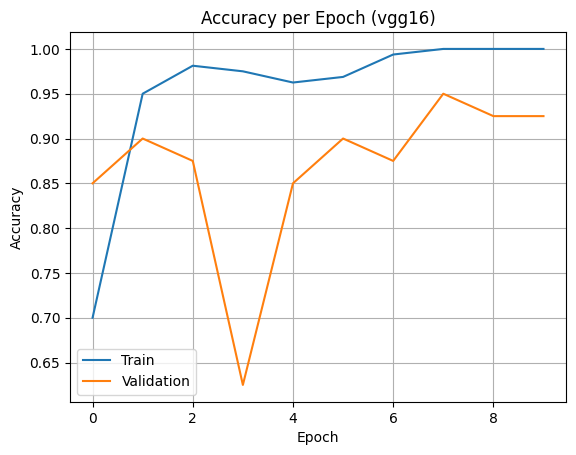


Training with RESNET18...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s] 


Epoch 1: Train Acc=0.6875, Val Acc=0.9000
Epoch 2: Train Acc=0.9938, Val Acc=0.9000
Epoch 3: Train Acc=1.0000, Val Acc=0.9250
Epoch 4: Train Acc=1.0000, Val Acc=0.9000
Epoch 5: Train Acc=1.0000, Val Acc=0.9000
Epoch 6: Train Acc=1.0000, Val Acc=0.9000
Epoch 7: Train Acc=1.0000, Val Acc=0.9000
Epoch 8: Train Acc=1.0000, Val Acc=0.9000
Epoch 9: Train Acc=1.0000, Val Acc=0.9000
Epoch 10: Train Acc=1.0000, Val Acc=0.9000


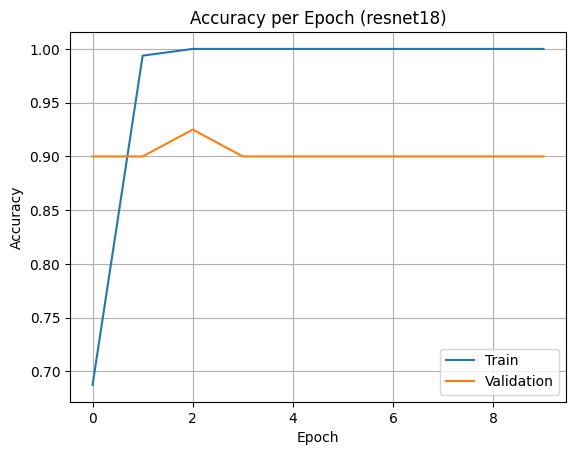


Training with MOBILENET...


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s] 


Epoch 1: Train Acc=0.6813, Val Acc=0.6500
Epoch 2: Train Acc=0.9062, Val Acc=0.9000
Epoch 3: Train Acc=0.9563, Val Acc=0.9000
Epoch 4: Train Acc=0.9938, Val Acc=0.9000
Epoch 5: Train Acc=1.0000, Val Acc=0.9000
Epoch 6: Train Acc=1.0000, Val Acc=0.9000
Epoch 7: Train Acc=1.0000, Val Acc=0.9000
Epoch 8: Train Acc=1.0000, Val Acc=0.9000
Epoch 9: Train Acc=1.0000, Val Acc=0.9000
Epoch 10: Train Acc=1.0000, Val Acc=0.9000


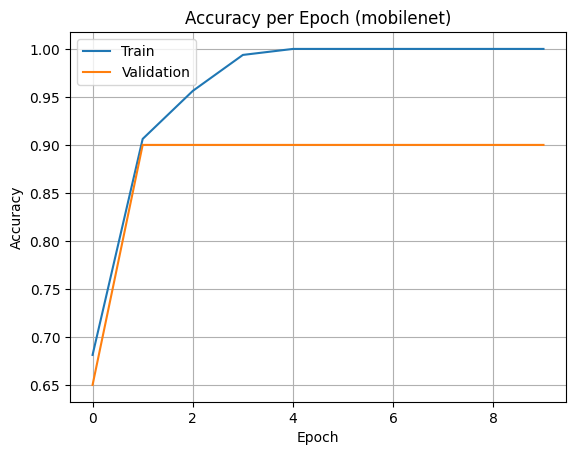

In [18]:
for model_name in ['vgg16', 'resnet18', 'mobilenet']:
    print(f"\nTraining with {model_name.upper()}...")
    model = get_model(model_name, num_classes)
    train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10)
    plot_acc(train_acc, val_acc, model_name)
